# Image compression/generation with Variational AutoEncoder

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image, ImageDraw, ImageFont
from matplotlib.lines import Line2D



In [2]:
charts = {
    'font_size':{
        'title': 26,
        'x_label': 18,
        'y_label': 18,
        'ticks': 14,
        'image_title': 20
    }
}

# Download dataset and define the model

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
epochs = 10
learning_rate = 1e-3
latent_dim = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Input is 1x28x28, output is 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # Output is 64x7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mu
        self.fc22 = nn.Linear(400, latent_dim)  # logvar
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 64 * 7 * 7)
        self.conv2_t = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1) # Output is 32x14x14
        self.conv1_t = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output is 1x28x28

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 64, 7, 7)
        z = F.relu(self.conv2_t(z))
        z = torch.sigmoid(self.conv1_t(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar):
    # Calculate the Binary Cross Entropy loss between the reconstructed image and the original image
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence measures how one probability distribution diverges from a second, expected probability distribution.
    # For VAEs, it measures how much information is lost when using the approximations of the distributions.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


# Model training

In [4]:
# Instantiate the model
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train():
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss
    

# Run the training
bar = tqdm(range(epochs), total=epochs, desc='Training model')
for _ in range(epochs):
    loss = train()
    bar.set_postfix(Loss=loss)
    bar.update(1)


Training model:   0%|          | 0/10 [00:00<?, ?it/s]

# Compress and Reconstruct images

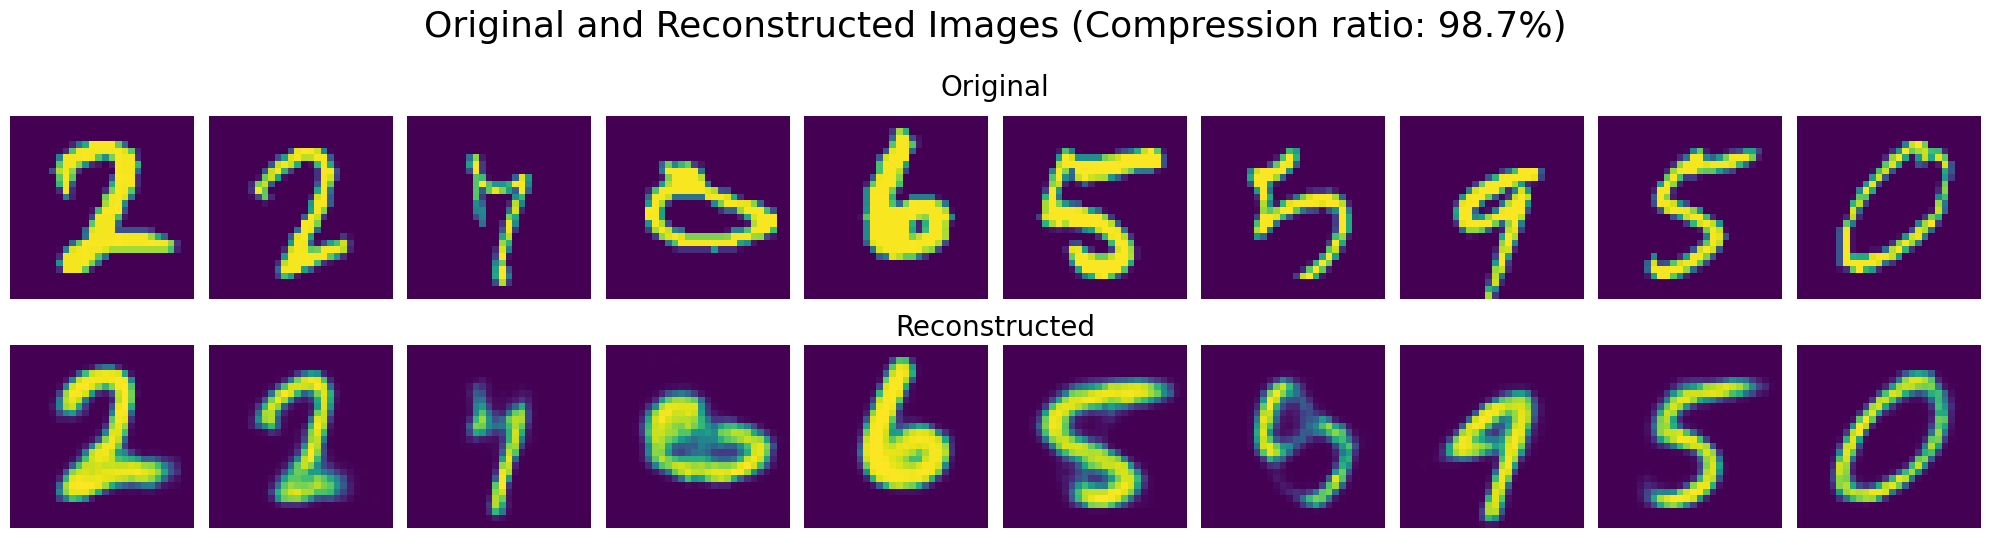

In [5]:
# Function to compress and reconstruct images
def compress_and_reconstruct(model, data):
    with torch.no_grad():
        data = data.to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        recon_batch = model.decode(z)
    return data.cpu(), recon_batch.cpu()

# Get a batch of test images
data_iter = iter(test_loader)
images, _ = next(data_iter)

# Compress and reconstruct the images
original_images, reconstructed_images = compress_and_reconstruct(model, images)

# Visualize the results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i][0])
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i][0])
    plt.axis('off')
plt.figtext(0.5, 0.85, 'Original', ha='center', va='center', fontsize=charts['font_size']['image_title'])
plt.figtext(0.5, 0.45, 'Reconstructed', ha='center', va='center', fontsize=charts['font_size']['image_title'])


plt.suptitle('Original and Reconstructed Images (Compression ratio: 98.7%)', fontsize=charts['font_size']['title'])
plt.tight_layout()
plt.savefig('../outputs/vae/vae_reconstruction.jpg')
plt.show()

Now we will retrain the model but this time using a latent dimension of 2. This is for visualization puposes so we can see the effect of changing the latent dimension values on the generated images.

In [6]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
bar = tqdm(range(epochs), total=epochs, desc='Training model')

for _ in range(epochs):
    loss = train()
    bar.set_postfix(Loss=loss, LR=optimizer.param_groups[0]['lr'])
    bar.update(1)

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

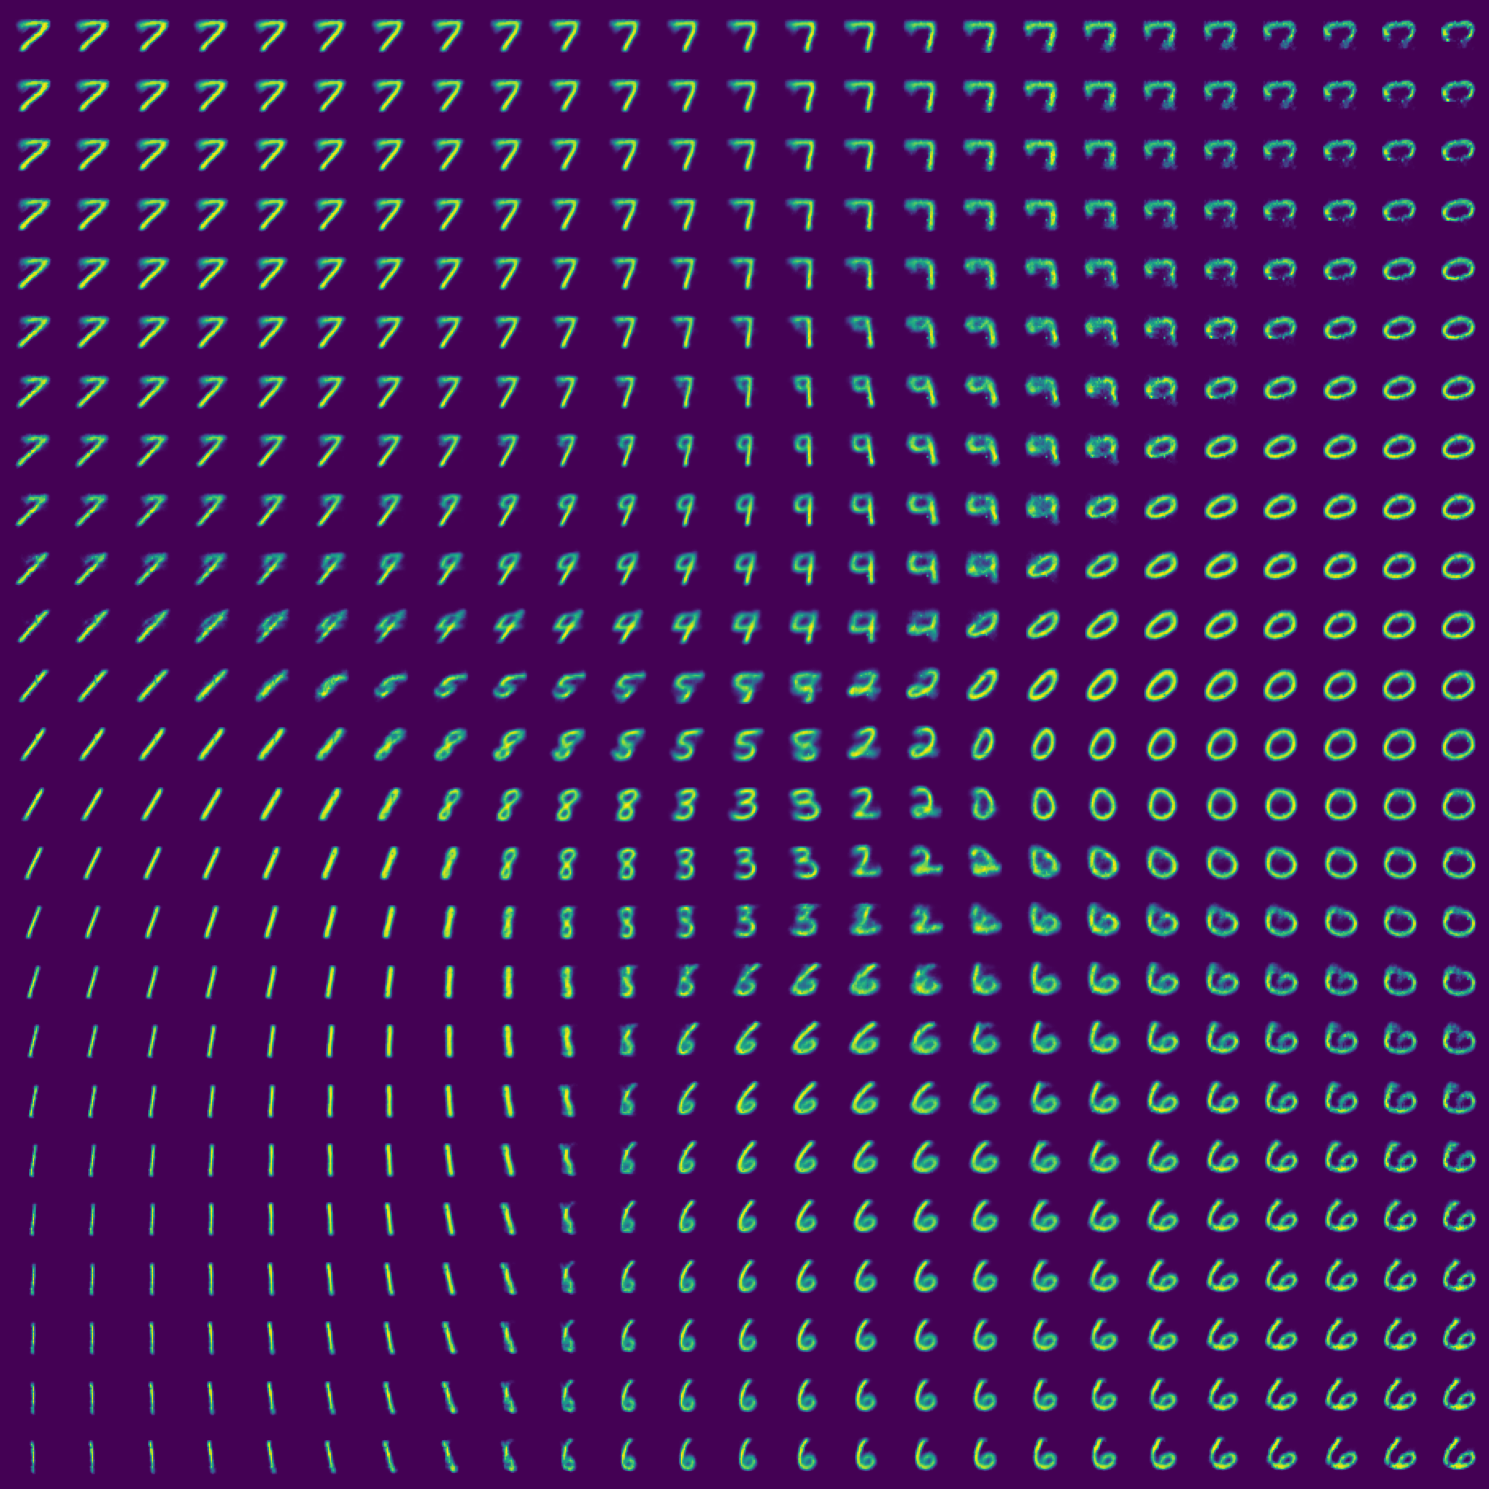

In [7]:
def generate_2d_grid_plot(x_range=(-3, 3), y_range=(-3, 3), n=25):
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)

    # Create the grid plot
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.patch.set_facecolor(plt.cm.viridis(0.0))
    
    with torch.no_grad():
        for i, yi in enumerate(y):
            for j, xi in enumerate(x):
                z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                generated = model.decode(z).view(28, 28)
                axes[i, j].imshow(generated.cpu().numpy())
                axes[i, j].axis('off')
                
                # Set the ticks for the leftmost column
                if j == 0:
                    axes[i, j].set_yticks([0])
                    axes[i, j].set_yticklabels([f"{yi:.1f}"])
                    
                # Set the ticks for the bottom row
                if i == n - 1:
                    axes[i, j].set_xticks([0])
                    axes[i, j].set_xticklabels([f"{xi:.1f}"])
    
    # Adjust layout
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.tight_layout()
    plt.savefig('../outputs/vae/vae_grid_plot.png')
    plt.show()

# Generate and display the 2D grid plot
generate_2d_grid_plot()



# Denoising

In [8]:
def add_noise(img, percentage=0.1):
    """
    Add random uniform noise to a percentage of the image's pixels.

    Parameters:
    - img (torch.Tensor): The original image tensor.
    - percentage (float): The fraction of pixels to which noise should be applied. Value between 0 and 1.

    Returns:
    - torch.Tensor: The noisy image.
    """
    # Ensure the percentage value is within the correct range
    assert 0 <= percentage <= 1, "Percentage must be between 0 and 1."

    # Create a random mask to select a subset of pixels based on the percentage
    mask = torch.rand(img.size()) < percentage

    # Generate uniform noise only where the mask is True
    # Noise scaled to [-1, 1] to simulate a wider range of noise
    noise = (torch.rand(img.size()) * 2) - 1
    noisy_img = img.clone()  # Make a copy to avoid modifying the original image
    noisy_img[mask] += noise[mask]

    # Clamp the values to ensure they are still valid image pixels
    return torch.clamp(noisy_img, 0., 1.)


class NoisyMNIST(Dataset):
    def __init__(self, mnist_dataset, noise_percentage=0.1):
        self.mnist_dataset = mnist_dataset
        self.noise_percentage = noise_percentage

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        original, _ = self.mnist_dataset[idx]  # original is clean
        noisy = add_noise(original, percentage=self.noise_percentage)
        return noisy, original  # return both noisy and clean image


# Example transformation and dataset initialization
def create_noisy_dataset(noise_percentage: float=0.1):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
    train_noisy_dataset = NoisyMNIST(train_dataset, noise_percentage=noise_percentage)

    test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
    test_noisy_dataset = NoisyMNIST(test_dataset, noise_percentage=noise_percentage)

    train_loader = DataLoader(dataset=train_noisy_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_noisy_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Plot the first 5 noisy images
def plot_images(loader):
    for images, _ in loader:
        plt.figure(figsize=(10, 2))
        for i, image in enumerate(images):
            if i >= 5:
                break
            plt.subplot(1, 5, i + 1)
            plt.imshow(image.squeeze())
            plt.tight_layout()
            plt.savefig(f'../outputs/vae/noisy_images_{i}.jpg')
            plt.axis('off')
        

In [9]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for noisy_data, original_data in train_loader:
        original_data = original_data.to(device)
        noisy_data = noisy_data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_data)
        loss= loss_function(recon_batch, original_data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

In [10]:
def remove_noise(model, test_loader):
    model.eval()
    with torch.no_grad():
        for noisy_data, _ in test_loader:
            noisy_data = noisy_data.to(device)
            recon_batch, _, _ = model(noisy_data)
            return noisy_data.cpu(), recon_batch.cpu().view(recon_batch.shape[0], 1, 28, 28)
        
def plot_noisy_vs_original(n, noise_percentage, test_loader):
    # Remove noise from the images
    noisy_images, denoised_images = remove_noise(model, test_loader)

    # Visualize the results
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'Noisy vs. Denoised Images (Noise Percentage = {noise_percentage})', fontsize=charts['font_size']['title'])
    for i in range(n):
        # Display noisy images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_images[i].squeeze())
        plt.axis('off')

        # Display denoised images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(denoised_images[i].squeeze())

        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'../outputs/vae/noisy_vs_denoised_{noise_percentage}.jpg')
    plt.show()

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

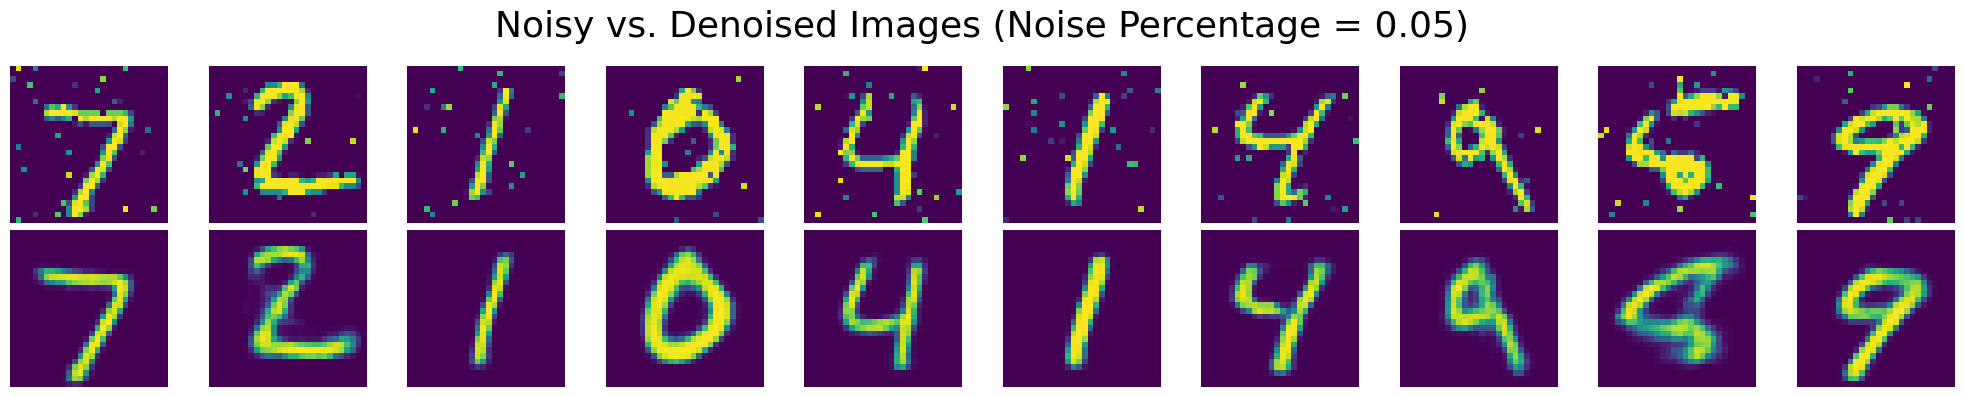

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

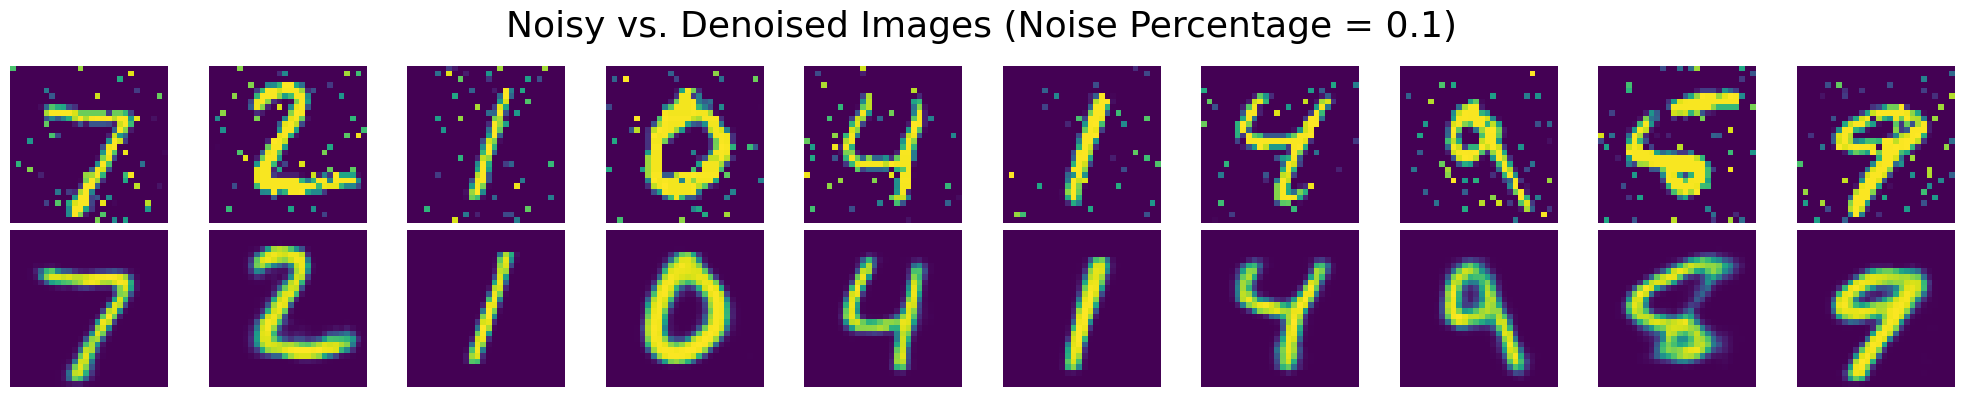

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

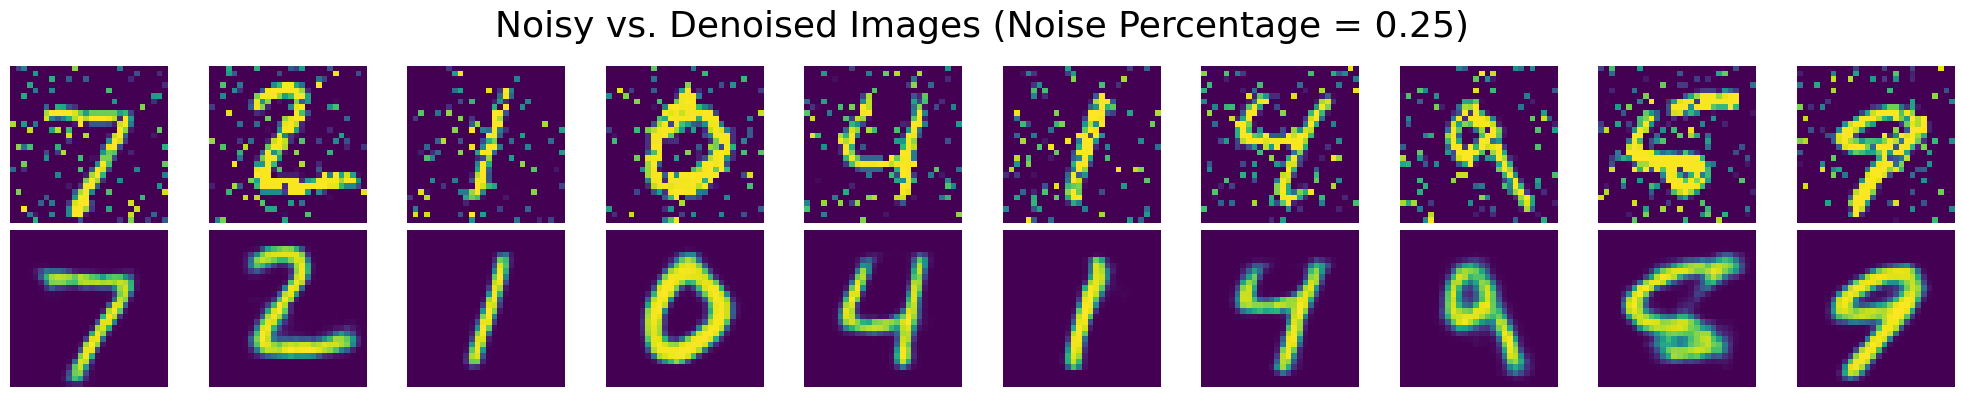

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

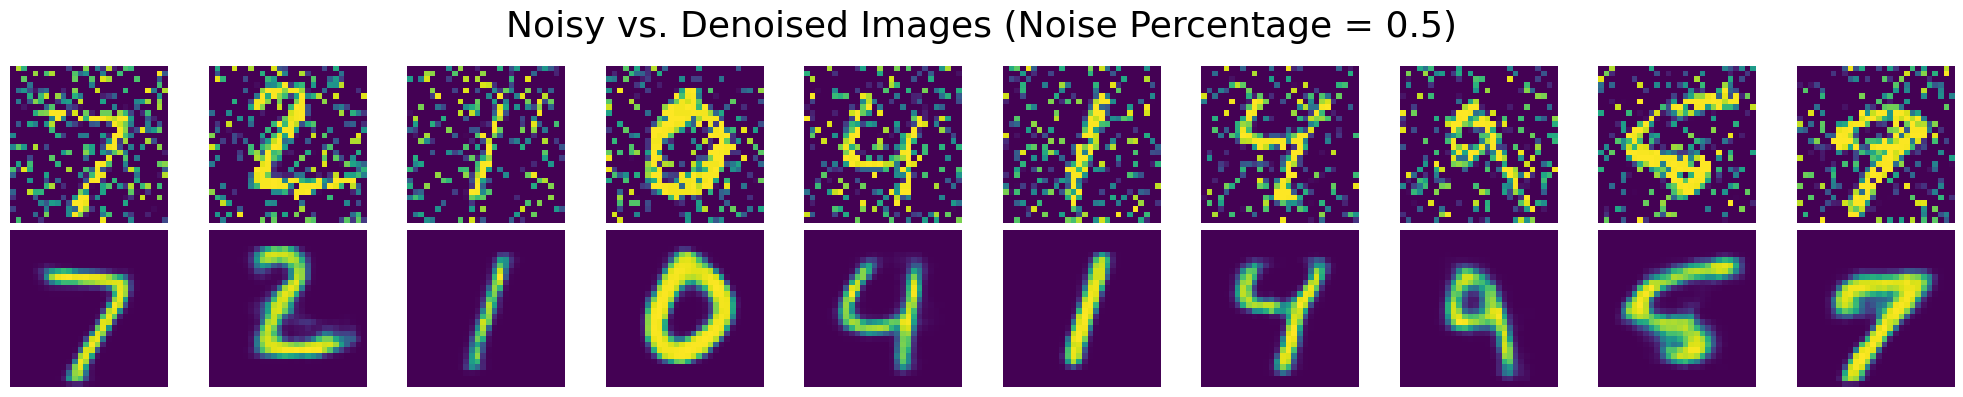

In [11]:
percentages = [0.05, 0.1, 0.25, 0.5]
losses = []
for p in percentages:
    model = VAE(latent_dim=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_loader, test_loader = create_noisy_dataset(noise_percentage=p)
    epochs = 20
    bar = tqdm(range(epochs), total=epochs, desc='Training model')

    for _ in range(epochs):
        loss = train(model, train_loader, optimizer)
        bar.set_postfix(Loss=loss)
        bar.update(1)
    losses.append(loss)
    plot_noisy_vs_original(10, noise_percentage=p, test_loader=test_loader)


# Anomaly detection

In [12]:
model = VAE(latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


def train():
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss
    

# Run the training
bar = tqdm(range(epochs), total=epochs, desc='Training model')
for _ in range(epochs):
    loss = train()
    bar.set_postfix(Loss=loss)
    bar.update(1)


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# Calculate the reconstruction error (MSE) per sample in the test set

def calculate_reconstruction_error(model, test_loader):
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for data, _ in test_loader:
            batch_size = data.size(0)
            data = data.to(device)
            recon_batch, _, _ = model(data)

            test_loss = F.mse_loss(recon_batch.view(batch_size, -1), data.view(batch_size, -1), reduction='none')
            test_loss = test_loss.sum(dim=1)
            batch_losses.append(test_loss)
        losses = torch.cat(batch_losses, dim=0)
        return losses.cpu().numpy()
                

In [14]:
reconstruction_errors = calculate_reconstruction_error(model, test_loader)

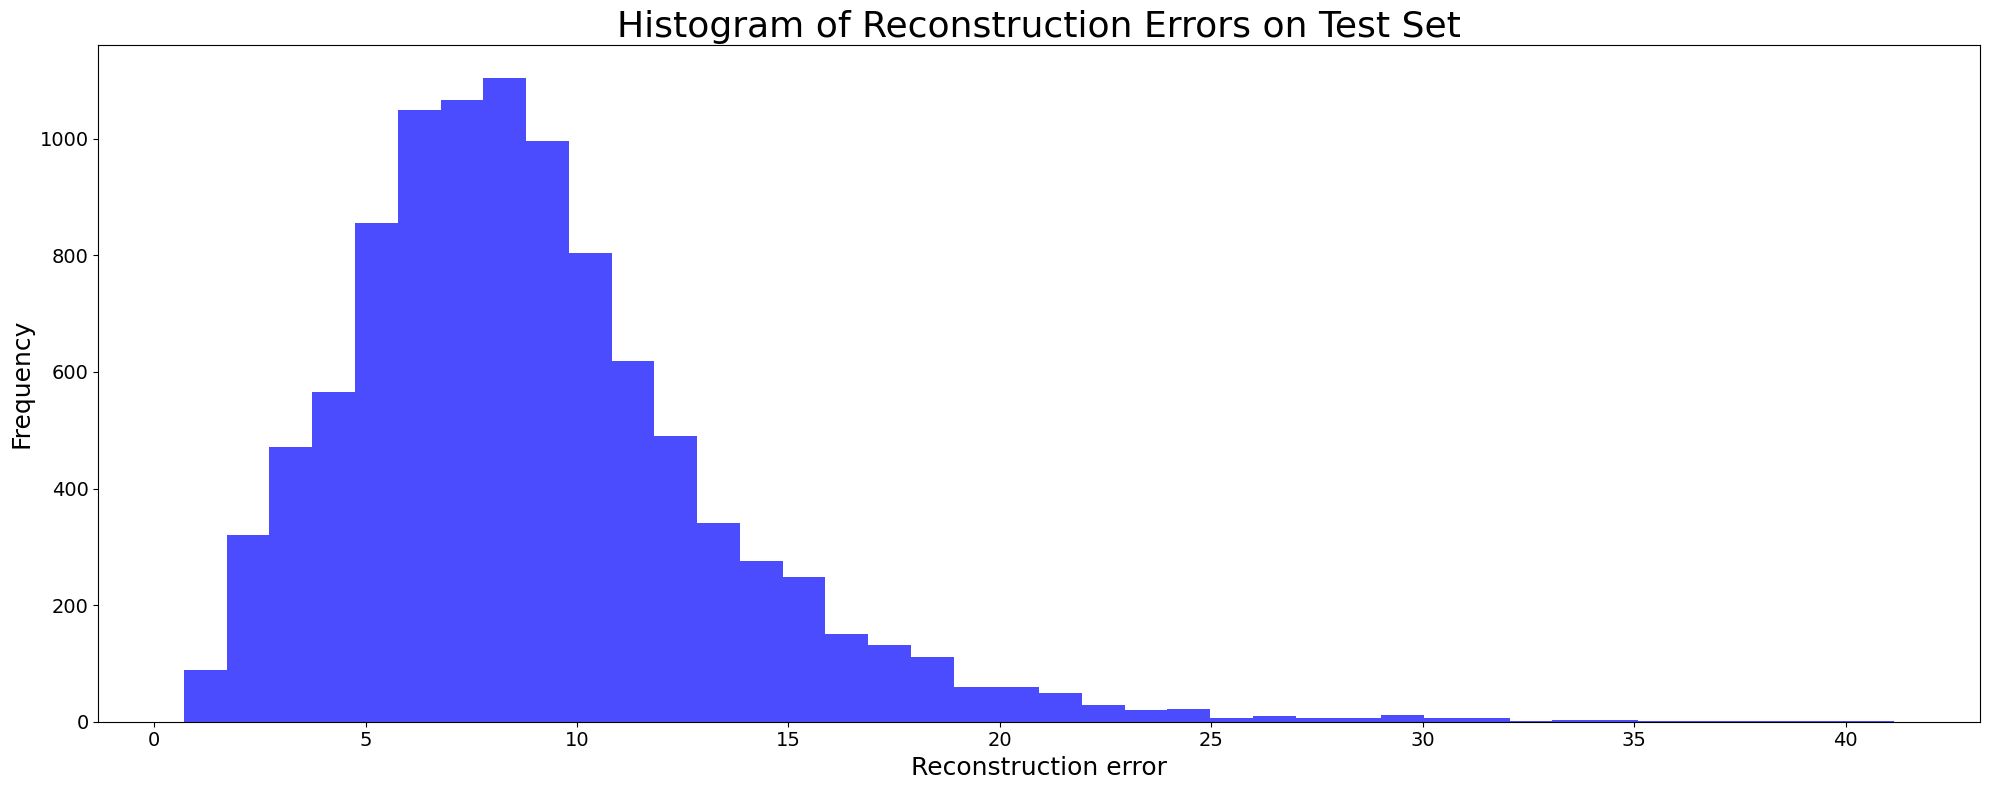

In [15]:
plt.figure(figsize=(20, 8))
plt.hist(reconstruction_errors, bins=40, color='blue', alpha=0.7)  # 30 bins, blue color, 70% opacity
plt.title('Histogram of Reconstruction Errors on Test Set', fontsize=charts['font_size']['title'])
plt.xlabel('Reconstruction error', fontsize=charts['font_size']['x_label'])
plt.ylabel('Frequency', fontsize=charts['font_size']['y_label'])
plt.xticks(fontsize=charts['font_size']['ticks'])
plt.yticks(fontsize=charts['font_size']['ticks'])
plt.tight_layout()
plt.savefig('../outputs/vae/reconstruction_errors_histogram.jpg')
plt.show()


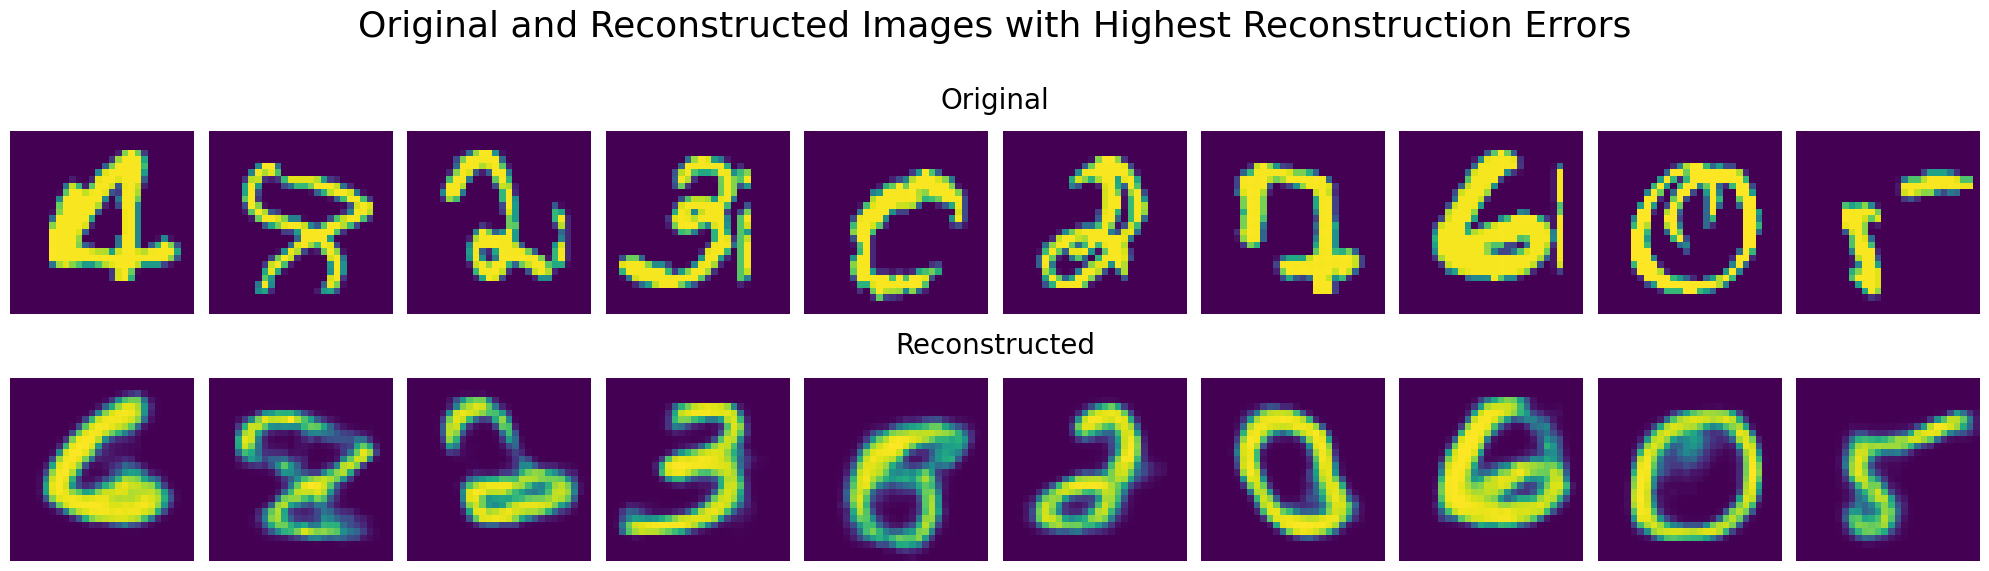

In [16]:
# Get the indices of the 3 samples with the highest reconstruction errors
n = 10

indices = np.argsort(reconstruction_errors)[::-1][:n]

# Get the corresponding images
images = []
for i in indices:
    image = test_dataset[i][0].squeeze().numpy()
    images.append(image)


# Plot original images in the top row
plt.figure(figsize=(20, 7))

for i, image in enumerate(images):
    plt.subplot(2, n, i + 1)  # 2 rows, n columns, position i+1 in the grid
    plt.imshow(image)
    plt.axis('off')

# Plot reconstructed images in the bottom row
for i, index in enumerate(indices):
    image, _ = test_dataset[index]
    image = image.to(device)
    with torch.no_grad():
        recon_batch, _, _ = model(image.unsqueeze(0))
    recon_image = recon_batch.squeeze().cpu().numpy()
    plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_image)
    plt.axis('off')
    plt.tight_layout()

plt.figtext(0.5, 0.85, 'Original', ha='center', va='center', fontsize=charts['font_size']['image_title'])
plt.figtext(0.5, 0.5, 'Reconstructed', ha='center', va='center', fontsize=charts['font_size']['image_title'])
plt.suptitle('Original and Reconstructed Images with Highest Reconstruction Errors', fontsize=charts['font_size']['title'])
plt.savefig('../outputs/vae/highest_reconstruction_errors.jpg')

plt.show()

In [17]:
def create_letter_image(letter, size=(28, 28)):
    # Create a blank image
    img = Image.new('L', size, color=0)
    draw = ImageDraw.Draw(img)

    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except IOError:
        font = ImageFont.load_default(size=24)

    # Get the bounding box of the letter
    bbox = draw.textbbox((0, 0), letter, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Calculate position to center the letter
    position = ((size[0] - w) / 2, (size[1] - h) / 2 - 7 )

    # Draw the letter
    draw.text(position, letter, fill=255, font=font)

    # Convert to numpy array
    letter_array = np.array(img) / 255

    return letter_array



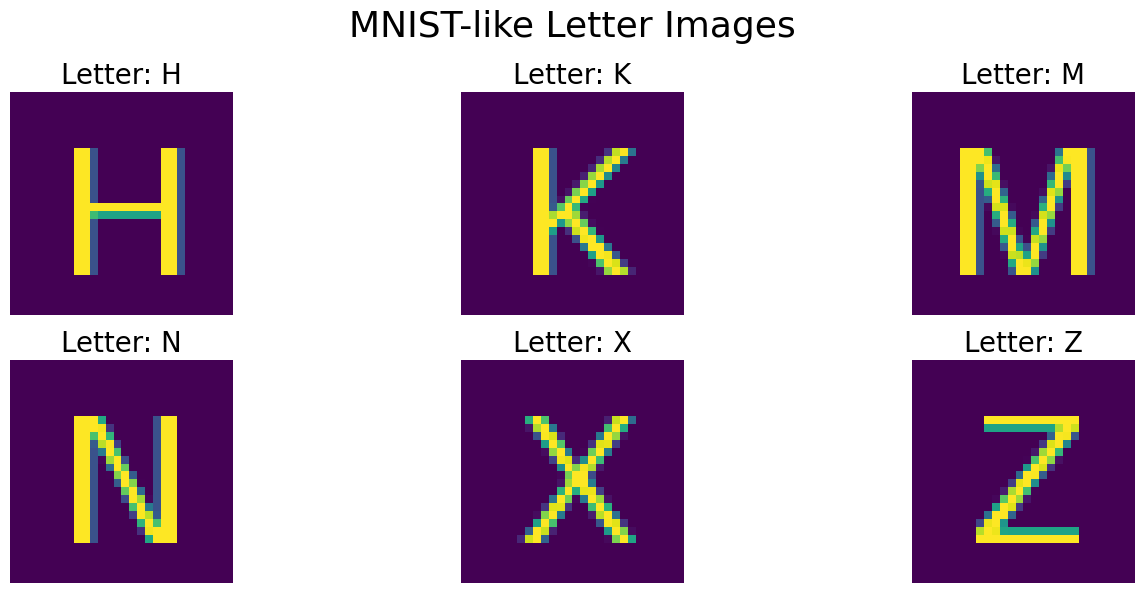

In [18]:
letters = ['H', 'K', 'M', 'N', 'X', 'Z']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
fig.suptitle("MNIST-like Letter Images", fontsize=charts['font_size']['title'])

# Flatten the axes array for easier iteration
axes = axes.flatten()

letter_images = []
# Create and display images for each letter
for i, letter in enumerate(letters):
    letter_image = create_letter_image(letter)
    letter_images.append(letter_image)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(letter_image)
    axes[i].set_title(f"Letter: {letter}", fontsize=charts['font_size']['image_title'])
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

In [19]:
letter_images = torch.tensor(np.array(letter_images)).unsqueeze(1).float().to(device)

In [20]:
# Feed the letter images through the model
with torch.no_grad():
    recon_letter_images, _, _ = model(letter_images)

batch_size = letter_images.shape[0]
letter_loss = F.mse_loss(recon_letter_images.view(batch_size, -1), letter_images.view(batch_size, -1), reduction='none')
letter_loss = letter_loss.sum(dim=1)


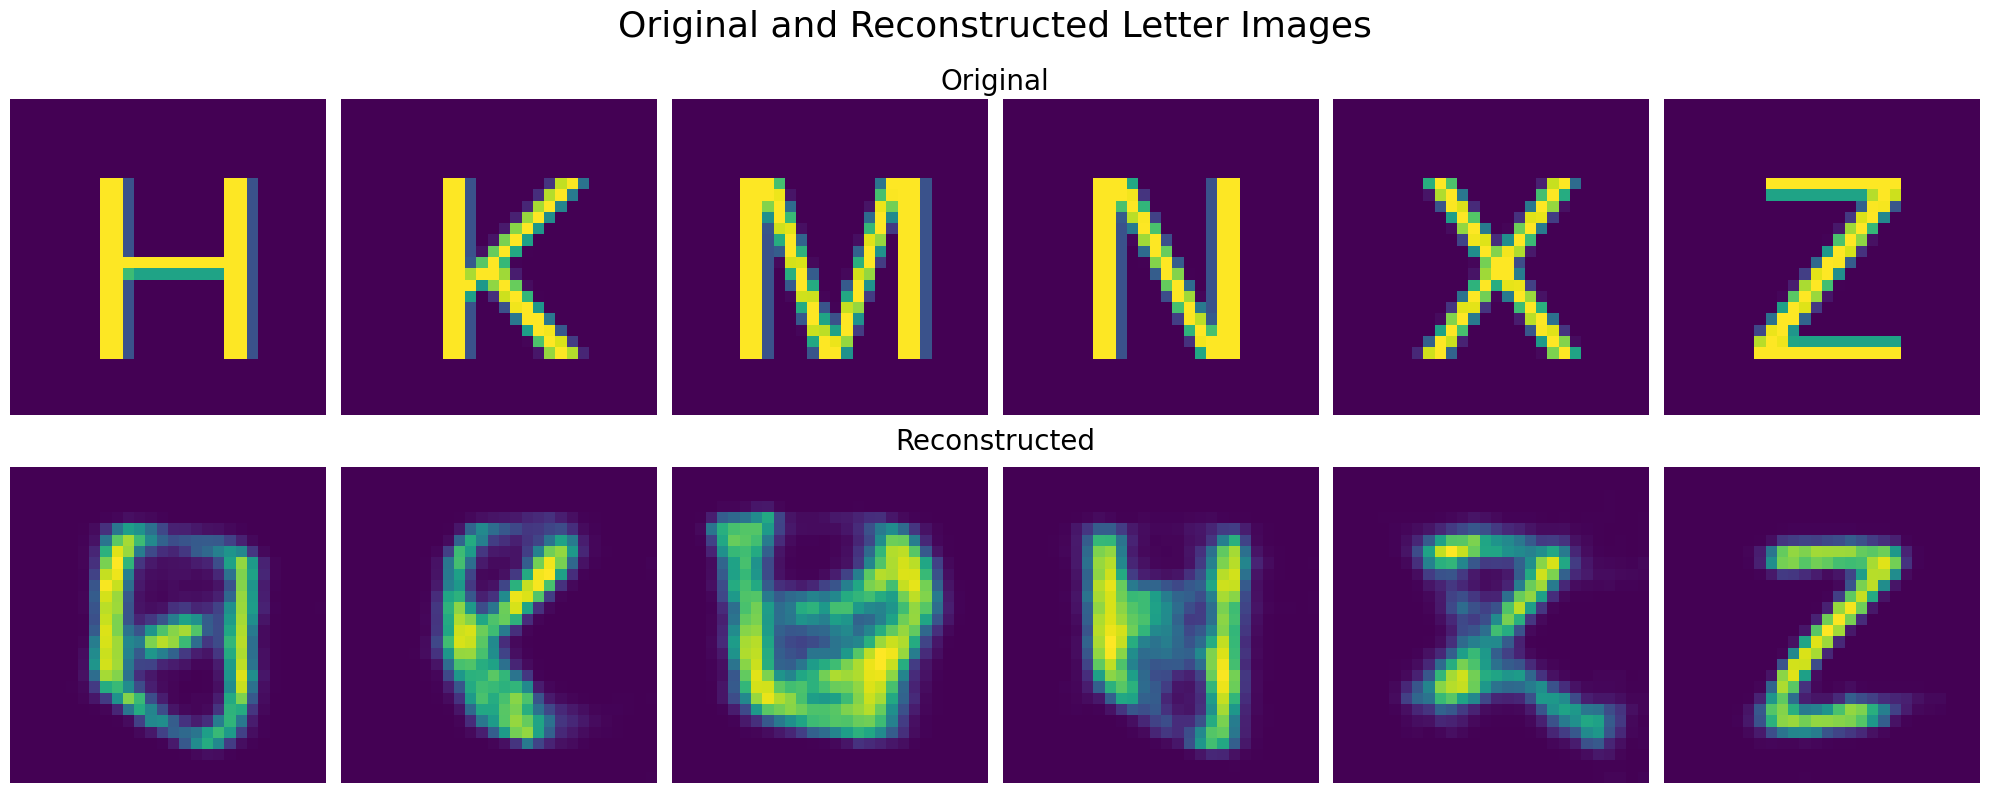

In [21]:
# Plot original images in the top row
n = 6
plt.figure(figsize=(20, 9))

for i, image in enumerate(letter_images):
    image = image.squeeze().cpu().numpy()
    plt.subplot(2, n, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Plot reconstructed images in the bottom row
for i, recon_image in enumerate(recon_letter_images):
    recon_image = recon_image.squeeze().cpu().numpy()
    plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_image)
    plt.axis('off')
    plt.tight_layout()

plt.figtext(0.5, 0.9, 'Original', ha='center', va='center', fontsize=charts['font_size']['image_title'])
plt.figtext(0.5, 0.5, 'Reconstructed', ha='center', va='center', fontsize=charts['font_size']['image_title'])
plt.suptitle('Original and Reconstructed Letter Images', fontsize=charts['font_size']['title'])
plt.savefig('../outputs/vae/letter_reconstruction.jpg')
plt.show()

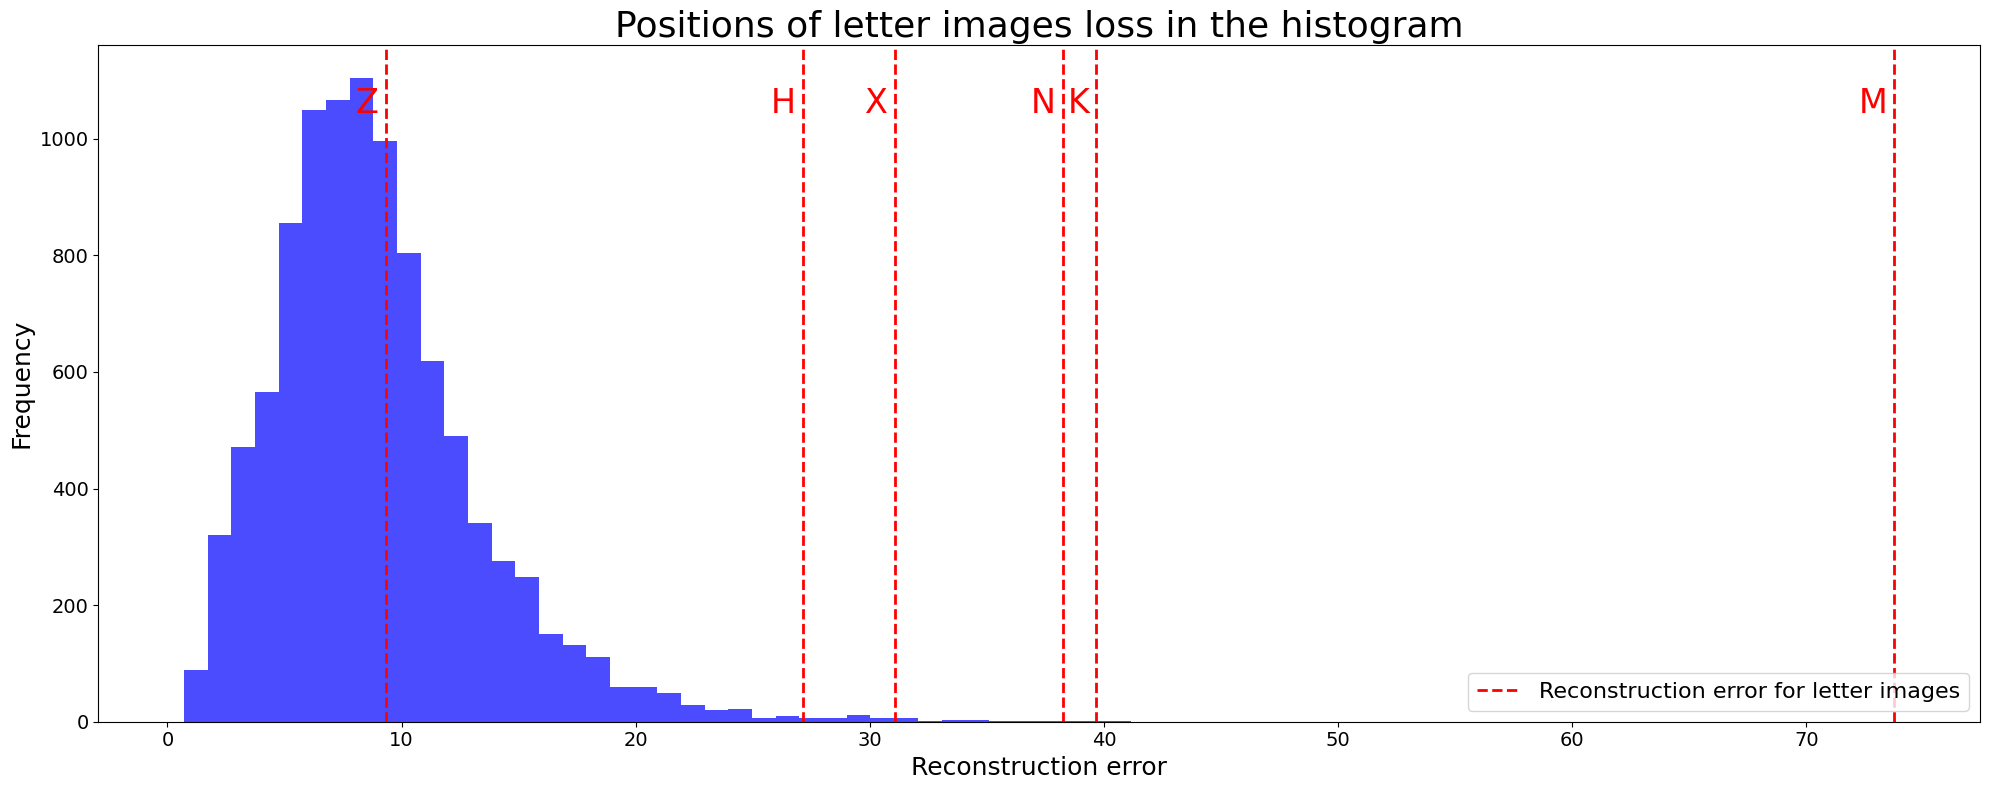

In [34]:
# Create histogram
plt.figure(figsize=(20, 8))
plt.hist(reconstruction_errors, bins=40, color='blue', alpha=0.7)
plt.title('Positions of letter images loss in the histogram', fontsize=charts['font_size']['title'])
plt.xlabel('Reconstruction error', fontsize=charts['font_size']['x_label'])
plt.ylabel('Frequency', fontsize=charts['font_size']['y_label'])
plt.xticks(fontsize=charts['font_size']['ticks'])
plt.yticks(fontsize=charts['font_size']['ticks'])

# Annotate specific values with red vertical arrows
for i, (value, letter) in enumerate(zip(letter_loss, letters)):
    plt.axvline(x=value.item(), color='red', linestyle='dashed', linewidth=2, label='Important threshold' if i == 0 else "")
    plt.text(value.item()-0.3, plt.ylim()[1]*0.9, f'{letter}', color='red', horizontalalignment='right', fontsize=24)

# Create a custom legend
legend_line = Line2D([0], [0], color='red', linestyle='dashed', linewidth=2)
plt.legend([legend_line], ['Reconstruction error for letter images'], loc='lower right', fontsize=16)
plt.tight_layout()
plt.savefig('../outputs/vae/reconstruction_errors_with_letters.jpg')
plt.show()

# Missing values imputation

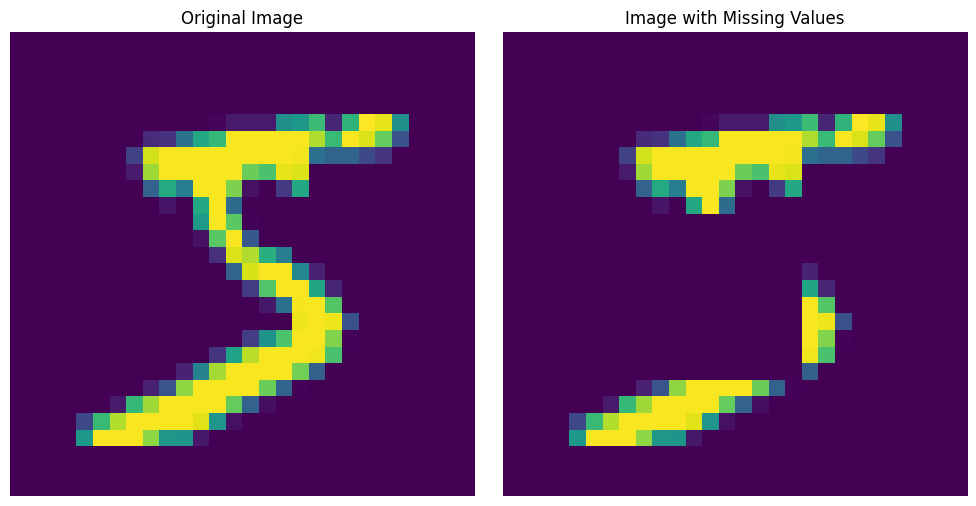

In [23]:
def remove_square(img, square_size=10):
    """Remove a randomly placed square of the given size near the center of the provided image."""
    middle = img.size(2) // 2
    max_deviation = square_size // 2  # Max deviation to ensure the center can be anywhere within the square
    
    # Random deviations that allow the center to be anywhere within the square
    deviation_x = random.randint(-max_deviation, max_deviation)
    deviation_y = random.randint(-max_deviation, max_deviation)

    # Calculate the top-left corner of the square
    start_x = middle + deviation_x - square_size // 2
    start_y = middle + deviation_y - square_size // 2

    # Ensure the square doesn't go out of the image boundaries
    start_x = max(0, min(start_x, img.size(2) - square_size))
    start_y = max(0, min(start_y, img.size(2) - square_size))

    # Ending coordinates of the square
    end_x = start_x + square_size
    end_y = start_y + square_size

    # Set the pixel values to 0 (black) in the square area
    img[:, start_y:end_y, start_x:end_x] = 0
    return img

# Example of processing the first image
img, _ = train_dataset[0]  # Get the first image and its label
img_missing = remove_square(img.clone())  # Clone to avoid modifying the original image

# Display the original and modified images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.squeeze())
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Missing Values')
plt.imshow(img_missing.squeeze())
plt.axis('off')
plt.tight_layout()
plt.savefig('../outputs/vae/missing_square.jpg')
plt.show()


In [24]:

class MNISTWithMissingSquares(Dataset):
    def __init__(self, root, train=True, transform=None, seed=42, square_size=8):
        """
        Custom MNIST dataset that includes a version of the image with a missing square.

        Parameters:
        - root (str): Root directory of dataset where MNIST raw dataset exists or will be saved.
        - train (bool): If True, creates dataset from training data; otherwise creates from test data.
        - transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
        - seed (int): Random seed for reproducibility of missing squares.
        - square_size (int): Size of the square to remove.
        """
        self.mnist = datasets.MNIST(root=root, train=train, download=True, transform=transform)
        self.seed = seed
        self.square_size = square_size
        random.seed(seed)

        # Process all images once
        self.original_imgs = []
        self.modified_imgs = []
        for img, _ in self.mnist:
            self.original_imgs.append(img)
            self.modified_imgs.append(self.remove_square(img.clone(), square_size))

    def remove_square(self, img, square_size=10):
        """Remove a randomly placed square of the given size near the center of the provided image."""
        middle = img.size(2) // 2
        max_deviation = square_size // 2
        
        deviation_x = random.randint(-max_deviation, max_deviation)
        deviation_y = random.randint(-max_deviation, max_deviation)

        start_x = middle + deviation_x - square_size // 2
        start_y = middle + deviation_y - square_size // 2

        start_x = max(0, min(start_x, img.size(2) - square_size))
        start_y = max(0, min(start_y, img.size(2) - square_size))

        end_x = start_x + square_size
        end_y = start_y + square_size

        img[:, start_y:end_y, start_x:end_x] = 0
        return img

    def __getitem__(self, index):
        return self.original_imgs[index], self.modified_imgs[index]

    def __len__(self):
        return len(self.mnist)

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_missing_dataset = MNISTWithMissingSquares(root='../data', train=True, transform=transform, seed=123, square_size=10)
test_missing_dataset = MNISTWithMissingSquares(root='../data', train=False, transform=transform, seed=123, square_size=10)

train_missing_loader = DataLoader(train_missing_dataset, batch_size=64, shuffle=True)
test_missing_loader = DataLoader(test_missing_dataset, batch_size=64, shuffle=False)

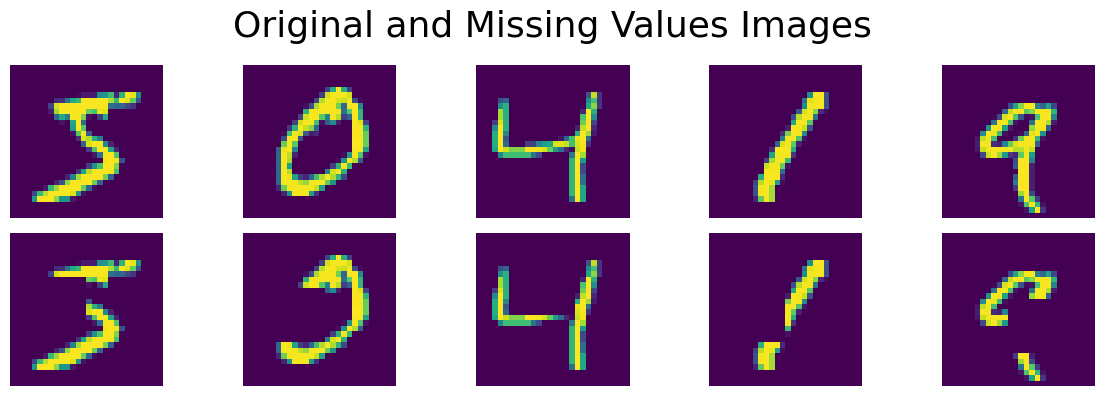

In [26]:

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
for i in range(5):
    original, modified = train_missing_dataset[i]
    axes[0, i].imshow(original.squeeze())
    axes[0, i].axis('off')
    axes[1, i].imshow(modified.squeeze())
    axes[1, i].axis('off')

plt.suptitle('Original and Missing Values Images', fontsize=charts['font_size']['title'])
plt.tight_layout()
plt.savefig('../outputs/vae/original_missing_images.jpg')
plt.show()

In [27]:
model = VAE(latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train():
    model.train()
    train_loss = 0
    for original, missing in train_missing_loader:
        original = original.to(device)
        missing = missing.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(missing)
        loss = loss_function(recon_batch, original, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss
    

# Run the training
bar = tqdm(range(epochs), total=epochs, desc='Training model')
for _ in range(epochs):
    loss = train()
    bar.set_postfix(Loss=loss)
    bar.update(1)


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
model.eval()
with torch.no_grad():
    for _, missing in test_missing_loader:
        missing = missing.to(device)

        reconstructed_missing , mu, logvar = model(missing)

        
missing = missing.cpu().numpy()
reconstructed_missing = reconstructed_missing.cpu().numpy()

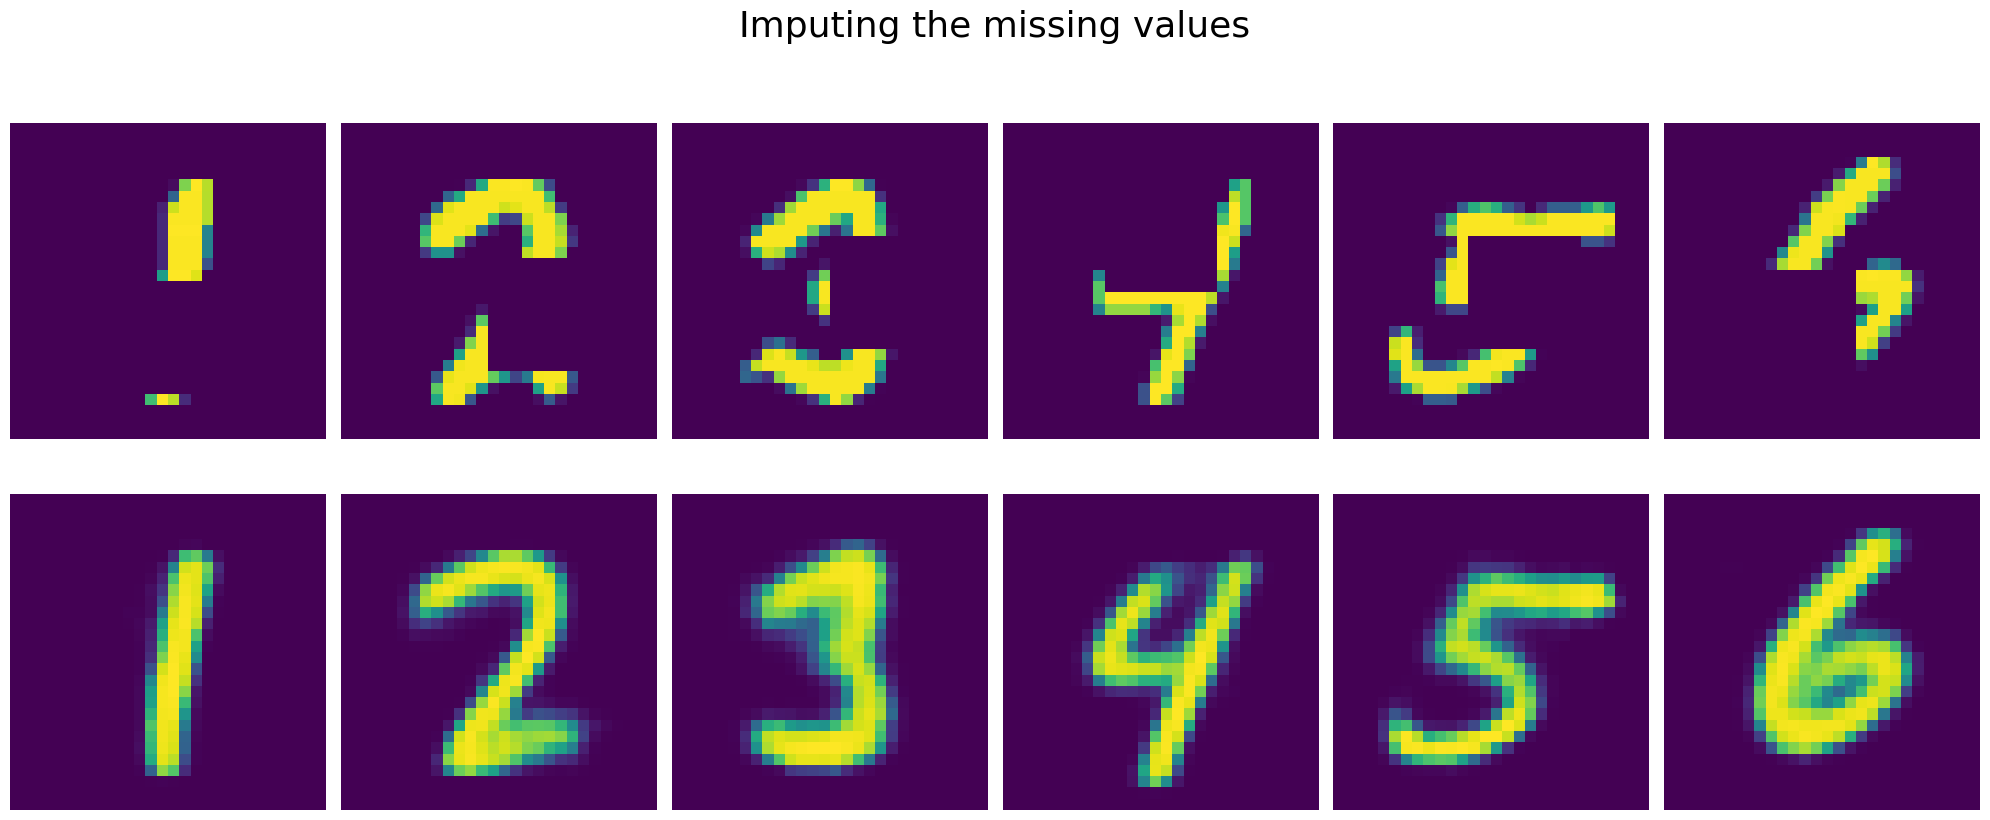

In [29]:
plt.figure(figsize=(20, 9))
plt.suptitle(f'Imputing the missing values', fontsize=charts['font_size']['title'])
for i in range(n):
    # Display noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(missing[i].squeeze())
    plt.axis('off')

    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_missing[i].squeeze())

    plt.axis('off')
plt.tight_layout()
plt.savefig(f'../outputs/vae/missing_vs_reconstructed.jpg')
plt.show()